In [1]:
%matplotlib inline

### Radar Plots
We make the radar plots for Watford's midfield trio and look for better players in other top 5 leagues

In [2]:
import pandas as pd
import numpy as np
import json
# plotting
import matplotlib.pyplot as plt
# statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
#opening data
import os
import pathlib
import warnings 
#used for plots
from scipy import stats
from mplsoccer import PyPizza, FontManager

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

### Opening data
For this task we will use Wyscout data. We open it, save in the dataframe
*train*. To avoid potential errors, we keep
only the data for which the beginning and end of an action was registered. 

In [3]:
train = pd.DataFrame()
with open('data/Wyscout/events_England.json') as f:
    data = json.load(f)
train = pd.concat([train, pd.DataFrame(data)])
#potential data collection error handling
train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]

### Calculating air and ground duels won

In [4]:
def wonDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won air and ground duels for a player 

    """
    #find air duels
    air_duels = df.loc[df["subEventName"] == "Air duel"]
    #703 is the id of a won duel
    won_air_duels = air_duels.loc[air_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    #group and sum air duels
    wad_player =  won_air_duels.groupby(["playerId"]).eventId.count().reset_index()
    wad_player.rename(columns = {'eventId':'air_duels_won'}, inplace=True)
    
    #find ground duels won
    ground_duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    wgd_player =  won_ground_duels.groupby(["playerId"]).eventId.count().reset_index()
    wgd_player.rename(columns = {'eventId':'ground_duels_won'}, inplace=True)
    
    #find anticipation
    ground_duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
    won_ground_duels = ground_duels.loc[ground_duels.apply (lambda x:{'id':20} in x.tags, axis = 1)]
    
    #outer join
    duels_won = wgd_player.merge(wad_player, how = "outer", on = ["playerId"])
    return duels_won

duels = wonDuels(train)
#investigate structure
duels.head(3)

,playerId,ground_duels_won,air_duels_won
0,0,1316.0,1061.0
1,36,17.0,23.0
2,38,6.0,11.0


### Interceptions

In [5]:
def interception(df):
    #find interceptions
    intercept = df.loc[df["eventId"] == 8]
    interception = intercept.loc[intercept.apply (lambda x:{'id':1401} in x.tags, axis = 1)]
    
    intercept_player =  interception.groupby(["playerId"]).eventId.count().reset_index()
    intercept_player.rename(columns = {'eventId':'interceptions'}, inplace=True)
    
    return intercept_player

interceptions = interception(train)
#investigate structure
interceptions.head(3)

,playerId,interceptions
0,36,23
1,38,11
2,48,103


### Passes

In [6]:
def passing(df):
    #find passes
    passes = df.loc[df["eventId"] == 8]
    good_pass = passes.loc[passes.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    bad_pass = passes.loc[passes.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
    
    good_pass_num =  good_pass.groupby(["playerId"]).eventId.count().reset_index()
    bad_pass_num =  bad_pass.groupby(["playerId"]).eventId.count().reset_index()
    
    good_pass_num.rename(columns = {'eventId':'successful_passes'}, inplace=True)
    bad_pass_num.rename(columns = {'eventId':'unsuccessful_passes'}, inplace=True)
    
    #outer join
    passes = good_pass_num.merge(bad_pass_num, how = "outer", on = ["playerId"])
    passes["pass_percent"] = round((passes['successful_passes']/(passes['successful_passes']+passes['unsuccessful_passes']))*100,2)
    
    return passes

# selecting first and last column
passing = passing(train).iloc[:, [0, -1]]
#investigate structure
passing.head(3)

,playerId,pass_percent
0,36,87.97
1,38,85.71
2,48,89.16


### Minutes Played
All data on our plot will be per 90 minutes played. Therefore, we need an information on the number of minutes played
throughout the season. To do so, we will use a prepared file that bases on the idea developed by students
taking part in course in 2021. Files with miutes per game for players in top 5 leagues can be found
[here](https://github.com/soccermatics/Soccermatics/tree/main/course/lessons/minutes_played). After downloading data and saving
it in out directory, we open it and store in a dataframe. Then we calculate the sum of miutes played in a season for each player.

In [7]:
with open('data/minutes_played_per_game_England.json') as f:
    minutes_per_game = json.load(f)
minutes_per_game = pd.DataFrame(minutes_per_game)
minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()

### Summary

In [8]:
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])
summary = summary.merge(duels, how = "left", on = ["playerId"]).merge(interceptions, how = "left", on = ["playerId"]).merge(passing, how = "left", on = ["playerId"])

summary = minutes.merge(summary, how = "left", on = ["playerId"])
summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]

In [9]:
summary

,playerId,minutesPlayed,ground_duels_won,air_duels_won,interceptions,pass_percent
0,36,1238,17.0,23.0,23.0,87.97
2,48,3343,71.0,137.0,103.0,89.16
3,54,3348,29.0,15.0,49.0,82.10
5,74,1514,30.0,48.0,36.0,93.10
6,93,2942,25.0,42.0,42.0,73.21
...,...,...,...,...,...,...
491,397178,1904,11.0,17.0,5.0,77.30
500,419784,405,9.0,4.0,12.0,85.45
502,434159,561,9.0,11.0,16.0,77.50
508,447812,499,13.0,8.0,7.0,73.68


### Filter for midfielders

In [10]:
with open('data/Wyscout/players.json') as f:
    players = json.load(f)
player_df = pd.DataFrame(players)
midfielders = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Midfielder", axis = 1)]
midfielders.rename(columns = {'wyId':'playerId'}, inplace=True)
to_merge = midfielders[['playerId', 'shortName']]
summary = summary.merge(to_merge, how = "inner", on = ["playerId"])

In [11]:
# Rename correctly to avoid future problems
summary.loc[88, "shortName"] = 'A. Doucoure'

### Calculating statistics per 90

In [12]:
summary_per_90 = pd.DataFrame()
summary_per_90["shortName"] = summary["shortName"]
for column in summary.columns[2:-2]:
    summary_per_90[column + "_per90"] = summary.apply(lambda x: x[column]*90/x["minutesPlayed"], axis = 1)

In [13]:
# Merging with pass completion
summary_per_90=summary_per_90.merge(summary[['shortName', 'pass_percent']], on='shortName', how='inner')

### Getting Watford midfield's data

In [14]:
# save to a csv file to be able to see where Watford's midfield trio are
summary_per_90.to_csv("midfielders.csv", index=False)

In [14]:
watford=summary_per_90.loc[[19,78,88]].reset_index(drop=True)
watford

,shortName,ground_duels_won_per90,air_duels_won_per90,interceptions_per90,pass_percent
0,T. Cleverley,1.754123,0.944528,1.709145,85.29
1,R. Pereyra,0.631210,0.210403,1.052016,85.92
2,A. Doucoure,1.801029,1.337907,2.727273,86.18


### Tom Cleverly's Radars

In [15]:
#player to investigate - T. Cleverley
#only his statistics
cleverly = summary_per_90.loc[summary_per_90["shortName"] == "T. Cleverley"]
#columns similar together
cleverly = cleverly[['ground_duels_won_per90', "air_duels_won_per90", "interceptions_per90", "pass_percent"]]
#take only necessary columns - exclude playerId
per_90_columns = cleverly.columns[:]
#values to mark on the plot
values = [round(cleverly[column].iloc[0],2) for column in per_90_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_per_90[column], cleverly[column].iloc[0])) for column in per_90_columns]

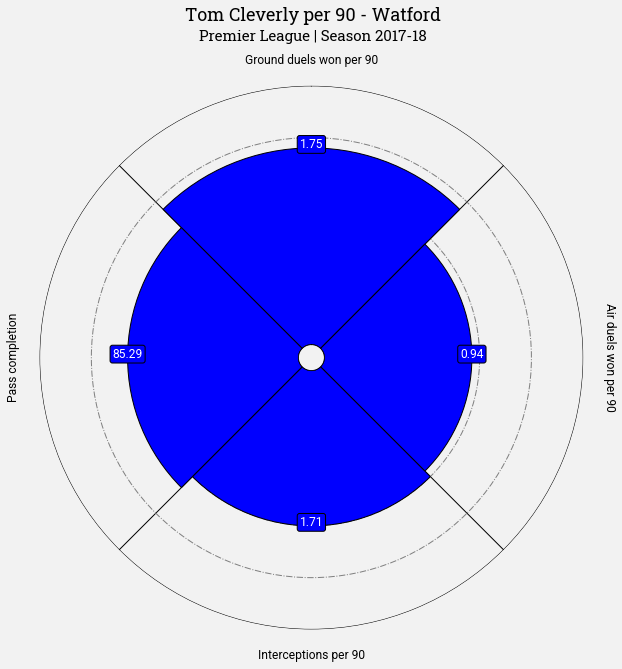

In [16]:
#list of names on plots
names = ["Ground duels won per 90", "Air duels won per 90", "Interceptions per 90", "Pass completion"]
slice_colors = ["blue"] * 4
text_colors = ["white"]*4
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Tom Cleverly per 90 - Watford", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.savefig("cleverly",bbox_figure="tight",dpi=300)
plt.show()

### Calculating possession

In [17]:
possesion_dict = {}
#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possesion_dict.keys():
        possesion_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60
    
    #get the dataframe of events from the game
    match_df = train.loc[train["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] = match_df.loc[match_df["matchPeriod"] == "2H", 'eventSec'] + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1]
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"].isin(["Air duel", "Ground defending duel","Ground loose ball duel"])].loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    #take team passes 
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possesion_dict[str(player_id)]["team_passes"] += len(team_passes)
    possesion_dict[str(player_id)]["all_passes"] += len(all_passes)

#calculate possesion for each player
percentage_dict = {key: value["team_passes"]/value["all_passes"] if value["all_passes"] > 0 else 0 for key, value in possesion_dict.items()}
#create a dataframe
percentage_df = pd.DataFrame(percentage_dict.items(), columns = ["playerId", "possesion"])
percentage_df["playerId"] = percentage_df["playerId"].astype(int)
#merge it
summary = summary.merge(percentage_df, how = "left", on = ["playerId"])

In [18]:
summary

,playerId,minutesPlayed,ground_duels_won,air_duels_won,interceptions,pass_percent,shortName,possesion
0,54,3348,29.0,15.0,49.0,82.10,C. Eriksen,0.606674
1,93,2942,25.0,42.0,42.0,73.21,J. Gu\u00f0munds\u00adson,0.438288
2,116,2495,38.0,21.0,41.0,90.94,G. Wijnaldum,0.576787
3,173,2211,34.0,18.0,20.0,75.36,R. van La Parra,0.478545
4,179,671,5.0,2.0,4.0,81.37,L. Narsingh,0.494446
...,...,...,...,...,...,...,...,...
144,346071,414,4.0,5.0,4.0,78.57,O. Burke,0.479093
145,353236,1995,18.0,14.0,26.0,80.00,T. Davies,0.450855
146,397174,678,12.0,10.0,12.0,89.02,S. McTominay,0.545495
147,419784,405,9.0,4.0,12.0,85.45,H. Choudhury,0.520446


### Adjusting data for possession

In [19]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]
#calculate value adjusted
for column in summary.columns[2:5]:
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["possesion"])*90/x["minutesPlayed"], axis = 1)

In [20]:
# Merging with pass completion
summary_adjusted=summary_adjusted.merge(summary_per_90[['shortName', 'pass_percent']], on='shortName', how='inner')

In [32]:
summary_adjusted

,shortName,ground_duels_won_adjusted_per90,air_duels_won_adjusted_per90,interceptions_adjusted_per90,pass_percent
0,C. Eriksen,1.284990,0.664650,2.171190,82.10
1,J. Gu\u00f0munds\u00adson,1.744941,2.931501,2.931501,73.21
2,G. Wijnaldum,2.376512,1.313335,2.564131,90.94
3,R. van La Parra,2.892077,1.531100,1.701222,75.36
4,L. Narsingh,1.356348,0.542539,1.085079,81.37
...,...,...,...,...,...
144,O. Burke,1.815024,2.268780,1.815024,78.57
145,T. Davies,1.801088,1.400846,2.601571,80.00
146,S. McTominay,2.920135,2.433446,2.920135,89.02
147,H. Choudhury,3.842857,1.707937,5.123810,85.45


### Making the plot with adjusted data for Tom Cleverly

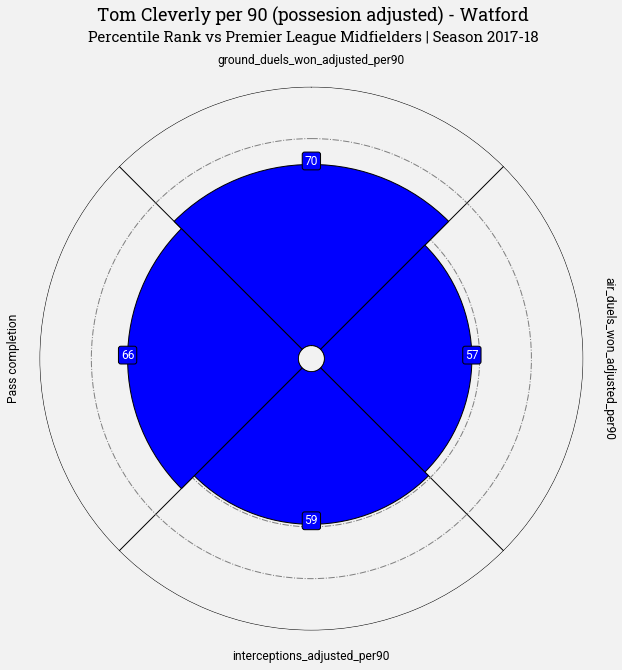

In [21]:
cleverly_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == "T. Cleverley"]
cleverly_adjusted = cleverly_adjusted[['ground_duels_won_adjusted_per90', "air_duels_won_adjusted_per90", "interceptions_adjusted_per90", "pass_percent"]]
#take only necessary columns
adjusted_columns = cleverly_adjusted.columns[:]
#values
values = [cleverly_adjusted[column].iloc[0] for column in adjusted_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], cleverly_adjusted[column].iloc[0])) for column in adjusted_columns]
names = names = ['ground_duels_won_adjusted_per90', "air_duels_won_adjusted_per90", "interceptions_adjusted_per90", "Pass completion"]


font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))

baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Tom Cleverly per 90 (possesion adjusted) - Watford", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Premier League Midfielders | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.savefig("cleverly_padj",bbox_figure="tight",dpi=300)
plt.show()

### R. Pereyra's	Radars

In [22]:
#player to investigate - R. Pereyra
#only his statistics
pereyra = summary_per_90.loc[summary_per_90["shortName"] == "R. Pereyra"]
#columns similar together
pereyra = pereyra[['ground_duels_won_per90', "air_duels_won_per90", "interceptions_per90", "pass_percent"]]
#take only necessary columns - exclude playerId
per_90_columns = pereyra.columns[:]
#values to mark on the plot
values = [round(pereyra[column].iloc[0],2) for column in per_90_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_per_90[column], pereyra[column].iloc[0])) for column in per_90_columns]

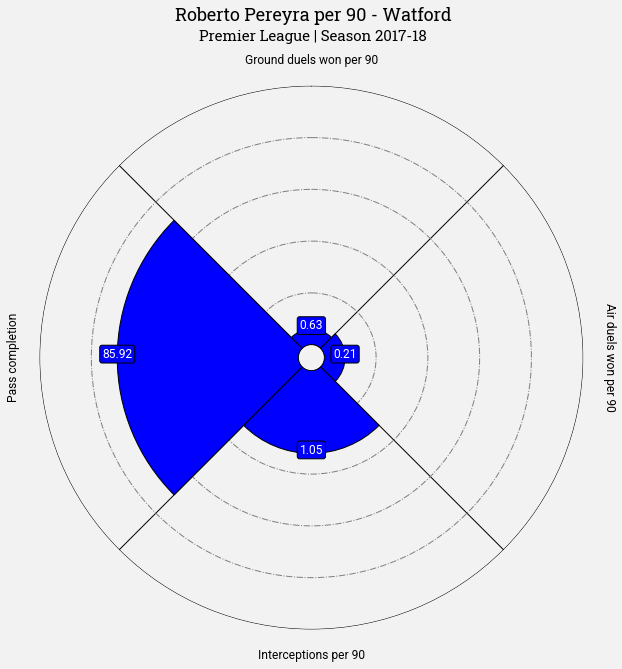

In [23]:
#list of names on plots
names = ["Ground duels won per 90", "Air duels won per 90", "Interceptions per 90", "Pass completion"]
slice_colors = ["blue"] * 4
text_colors = ["white"]*4
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Roberto Pereyra per 90 - Watford", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.savefig("pereyra",bbox_figure="tight",dpi=300)
plt.show()

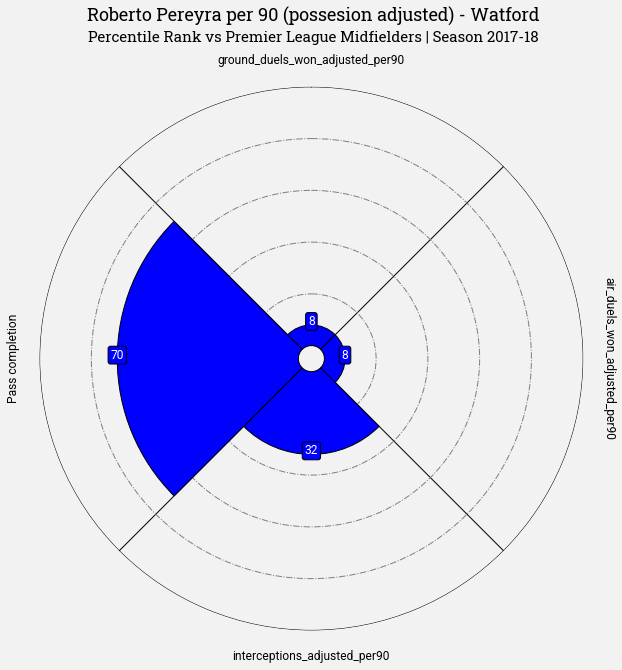

In [24]:
pereyra_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == "R. Pereyra"]
pereyra_adjusted = pereyra_adjusted[['ground_duels_won_adjusted_per90', "air_duels_won_adjusted_per90", "interceptions_adjusted_per90", "pass_percent"]]
#take only necessary columns
adjusted_columns = pereyra_adjusted.columns[:]
#values
values = [pereyra_adjusted[column].iloc[0] for column in adjusted_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], pereyra_adjusted[column].iloc[0])) for column in adjusted_columns]
names = names = ['ground_duels_won_adjusted_per90', "air_duels_won_adjusted_per90", "interceptions_adjusted_per90", "Pass completion"]


font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))

baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Roberto Pereyra per 90 (possesion adjusted) - Watford", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Premier League Midfielders | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.savefig("pereyra_padj",bbox_figure="tight",dpi=300)
plt.show()

### A. Doucoure's Radars

In [25]:
#player to investigate - A. Doucoure
#only his statistics
doucoure = summary_per_90.loc[summary_per_90["shortName"] == "A. Doucoure"]
#columns similar together
doucoure = doucoure[['ground_duels_won_per90', "air_duels_won_per90", "interceptions_per90", "pass_percent"]]
#take only necessary columns - exclude playerId
per_90_columns = doucoure.columns[:]
#values to mark on the plot
values = [round(doucoure[column].iloc[0],2) for column in per_90_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_per_90[column], doucoure[column].iloc[0])) for column in per_90_columns]

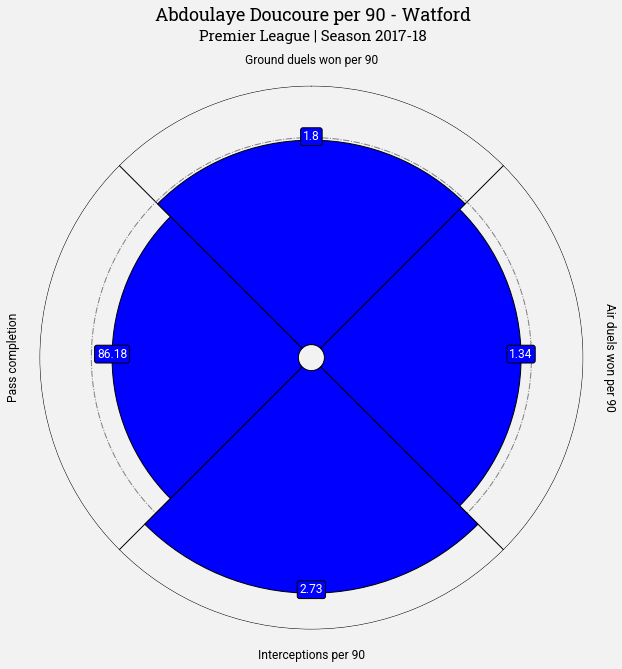

In [26]:
#list of names on plots
names = ["Ground duels won per 90", "Air duels won per 90", "Interceptions per 90", "Pass completion"]
slice_colors = ["blue"] * 4
text_colors = ["white"]*4
font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))
#PIZZA PLOT
baker = PyPizza(
    params=names,   
    min_range = None,
    max_range = None,               # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)
#making pizza for our data
fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors, # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

#putting text
texts = baker.get_value_texts()
for i, text in enumerate(texts):
    text.set_text(str(values[i]))
# add title
fig.text(
    0.515, 0.97, "Abdoulaye Doucoure per 90 - Watford", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Premier League | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.savefig("doucoure",bbox_figure="tight",dpi=300)
plt.show()

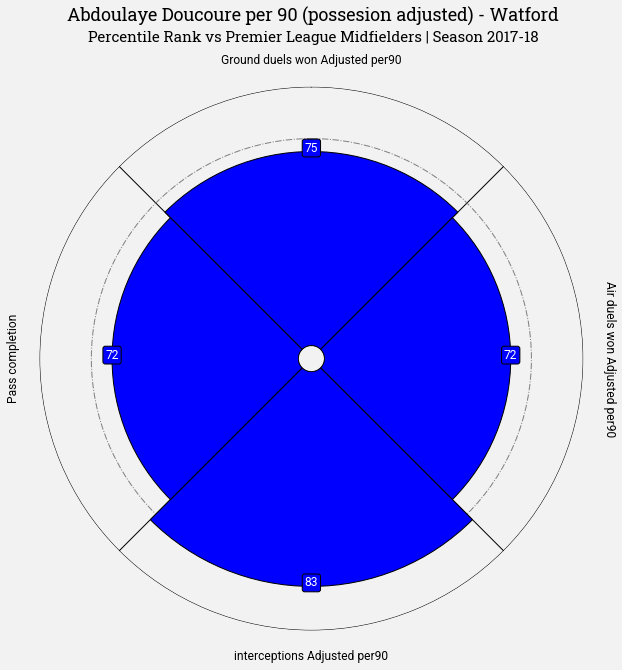

In [27]:
doucoure_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == "A. Doucoure"]
doucoure_adjusted = doucoure_adjusted[['ground_duels_won_adjusted_per90', "air_duels_won_adjusted_per90", "interceptions_adjusted_per90", "pass_percent"]]
#take only necessary columns
adjusted_columns = doucoure_adjusted.columns[:]
#values
values = [doucoure_adjusted[column].iloc[0] for column in adjusted_columns]
#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], doucoure_adjusted[column].iloc[0])) for column in adjusted_columns]
names = names = ['Ground duels won Adjusted per90', "Air duels won Adjusted per90", "interceptions Adjusted per90", "Pass completion"]


font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                           "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                         "RobotoSlab%5Bwght%5D.ttf?raw=true"))

baker = PyPizza(
    params=names,                  # list of parameters
    straight_line_color="#000000",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=1,              # linewidth for other circles
    other_circle_ls="-."            # linestyle for other circles
)

fig, ax = baker.make_pizza(
    percentiles,              # list of values
    figsize=(10, 10),      # adjust figsize according to your need
    param_location=110,
    slice_colors=slice_colors,
    value_colors = text_colors,
    value_bck_colors=slice_colors,
    # where the parameters will be added
    kwargs_slices=dict(
        facecolor="cornflowerblue", edgecolor="#000000",
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, va="center"
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                    # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.97, "Abdoulaye Doucoure per 90 (possesion adjusted) - Watford", size=18,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank vs Premier League Midfielders | Season 2017-18",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

plt.savefig("doucoure_padj",bbox_figure="tight",dpi=300)
plt.show()